# Modeling the Tissue-curve for the PET-Center Turku

### First we need to import libraries for the analysis:

Numpy is a numerical library that provides mathematical tools for python. Matplotlib is used for plotting and pandas is used for dataframe manipulation. Scipy is a library that provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems. From scipy we only need functions for optimization and interpolation.

We also have created a python module called functions where we define more functions. We explain aforementioned functions as we use them but you can also view the source code in the same source as this notebook.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as optimize
from functions import *

### Importing data

The data is provided in one Excel-file that has multiple sheets. We need to iterate through all of the sheets and save the data from each one of the sheets to the pandas dataframe for easier access. In the loop we iterate through all of the sheets, add them to a list of dataframes and in the end combine all six of the dataframes into one main dataframe.

We are also defining a new variable in the dataframe called midpoint. Midpoint is a real value that is defined as the midwaypoint between the time_start and the time_end timestamps.

In [12]:
data = pd.read_excel("D:\GitHub\SMAT_projekti\src\TACs.xlsx", sheet_name=None)
relevant_keys = ['PT 300 ml Qclear 2', 'PT 300 ml Qclear 1', 'PT 200 ml Qclear 2', 'PT 200 ml Qclear 1', 'PT 100 ml Qclear 2', 'PT 100 ml Qclear 1']
samples = [2, 1, 2, 1, 2, 1]
flows = [300, 300, 200, 200, 100, 100]
frames = []

for key, sample, flow in zip(relevant_keys, samples, flows):
    frame = data[key]
    df = frame.loc[5:]
    df.columns = ["time", "input", "tissue"]
    df[['time_start', 'time_end']] = df['time'].str.split(' - ', 1, expand=True)
    df = df.assign(sample=sample, flow=flow)
    df = df.astype({'input': 'float64', 'tissue': 'float64', 'time_start': 'int32', 'time_end': 'int32'})
    df = df.drop(["time"], axis=1)
    df["midpoint"] = (df["time_end"] + df["time_start"]) / 2
    frames.append(df)
df = pd.concat(frames)
df

C:\Users\Patonki\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,input,tissue,time_start,time_end,sample,flow,midpoint
5,1.456478e+03,407.96191,0,5,2,300,2.5
6,1.278932e+03,459.05683,5,10,2,300,7.5
7,2.265328e+04,646.44457,10,15,2,300,12.5
8,4.574733e+05,10505.08901,15,20,2,300,17.5
9,1.643083e+06,89934.22971,20,25,2,300,22.5
...,...,...,...,...,...,...,...
24,1.392625e+06,784895.39999,140,160,1,100,150.0
25,6.902623e+05,925024.12368,160,190,1,100,175.0
26,2.563172e+05,870937.93689,190,220,1,100,205.0
27,7.789175e+04,634442.87209,220,250,1,100,235.0


### Creating more features

In our model we are going to need more features than we have in the dataset. We are needing the timepoint where the input curve reaches it's maximum value. We also need to calculate the integral for the tissue curve as we are going to normalize it so the optimization problem becomes easier later on.

We group the dataframe by different flow and sample values and calculate aforementioned values for each of the subdataframes. In the end we create a pandas dataframe from our dictionary and merge it with our original dataframe.

In [13]:
feature_df = {
    "flow": [],
    "sample": [],
    "tissue_integral": [],
    "input_x_max": [],
    "tissue_x_max": []
}

for name, group in df.groupby(['sample', 'flow']):
    feature_df["flow"].append(group["flow"].iloc[0])
    feature_df["sample"].append(group["sample"].iloc[0])

    # Creating interpolation out of both functions
    cubic_input = interp1d(group["midpoint"], group["input"], kind='cubic')
    cubic_tissue = interp1d(group["midpoint"], group["tissue"], kind='cubic')
    min_inter, max_inter = min(group["midpoint"]), max(group["midpoint"])

    # Finding in which timepoint the input function reaches maximum flow value
    results = optimize.minimize(lambda x: -cubic_input(x), x0=(100), bounds = [(min_inter + 1, max_inter - 1)])
    feature_df["input_x_max"].append(results["x"][0])

    # Finding in which timepoint the tissue function reaches maximum flow value
    results = optimize.minimize(lambda x: -cubic_tissue(x), x0=(100), bounds = [(min_inter + 1, max_inter - 1)])
    feature_df["tissue_x_max"].append(results["x"][0])

    # Finding the integral of the tissue function
    integral = np.trapz(group["tissue"], x=group["midpoint"])
    feature_df["tissue_integral"].append(integral)

feature_df = pd.DataFrame(feature_df)
df = pd.merge(df, feature_df, how="left", on=["flow", "sample"])
df

,input,tissue,time_start,time_end,sample,flow,midpoint,tissue_integral,input_x_max,tissue_x_max
0,1.456478e+03,407.96191,0,5,2,300,2.5,4.000549e+07,28.483993,47.474075
1,1.278932e+03,459.05683,5,10,2,300,7.5,4.000549e+07,28.483993,47.474075
2,2.265328e+04,646.44457,10,15,2,300,12.5,4.000549e+07,28.483993,47.474075
3,4.574733e+05,10505.08901,15,20,2,300,17.5,4.000549e+07,28.483993,47.474075
4,1.643083e+06,89934.22971,20,25,2,300,22.5,4.000549e+07,28.483993,47.474075
...,...,...,...,...,...,...,...,...,...,...
139,1.392625e+06,784895.39999,140,160,1,100,150.0,1.091706e+08,118.793714,182.669710
140,6.902623e+05,925024.12368,160,190,1,100,175.0,1.091706e+08,118.793714,182.669710
141,2.563172e+05,870937.93689,190,220,1,100,205.0,1.091706e+08,118.793714,182.669710
142,7.789175e+04,634442.87209,220,250,1,100,235.0,1.091706e+08,118.793714,182.669710


Now we are creating a new variable called scaled_tissue. Scaled_tissue is the value of the tissue function divided (scaled) by it's total integral.

In [14]:
df["scaled_tissue"] = df["tissue"] / df["tissue_integral"]

### Sampling from original dataset:

In the original dataset we had issues when the readings where done in infrequent times. At the beginning the readings were taken every 5 seconds but later on the frequency was lowered to 20 seconds. We are going to fix this by sampling set amount of points in even intervals from the original curve. We are doing this by using get_interpolated_sample function that takes data that is grouped by flow and sample, then the function fits a cubic split interpolation into the data. Finally we sample set amount of points (currently 500) in even intervals from the interpolation. Variable x in the dataframe is the timepoint where we calculate the y-value from the interpolation.

In [15]:
sampled_dict = {
    "x": [],
    "ss_tissue": [],
    "s_tissue": [],
    "sample": [],
    "flow": []
}

num_samples = 500
for name, group in df.groupby(['sample', 'flow']):
    results = get_interpolated_sample(
        min(df["midpoint"]),
        max(df["midpoint"]),
        group, 
        num_samples, 
        ["scaled_tissue", "tissue"], 
        "midpoint"
    )
    sampled_dict["x"].append(results[0])
    sampled_dict["ss_tissue"].append(results[1][0])
    sampled_dict["s_tissue"].append(results[1][1])
    sampled_dict["sample"].append(np.repeat(group["sample"].iloc[0], num_samples))
    sampled_dict["flow"].append(np.repeat(group["flow"].iloc[0], num_samples))

open_list = lambda x: [item for sublist in x for item in sublist]

for key in sampled_dict.keys():
    sampled_dict[key] = open_list(sampled_dict[key])

sampled_df = pd.DataFrame(sampled_dict)
sampled_df = pd.merge(sampled_df, feature_df, how="inner", on=["sample", "flow"])
sampled_df


,x,ss_tissue,s_tissue,sample,flow,tissue_integral,input_x_max,tissue_x_max
0,2.500000,0.000012,1267.153700,1,100,1.091706e+08,118.793714,182.669710
1,3.026052,0.000012,1272.243678,1,100,1.091706e+08,118.793714,182.669710
2,3.552104,0.000012,1277.155441,1,100,1.091706e+08,118.793714,182.669710
3,4.078156,0.000012,1281.909044,1,100,1.091706e+08,118.793714,182.669710
4,4.604208,0.000012,1286.524541,1,100,1.091706e+08,118.793714,182.669710
...,...,...,...,...,...,...,...,...
2995,262.895792,0.000034,1360.482562,2,300,4.000549e+07,28.483993,47.474075
2996,263.421844,0.000034,1357.702401,2,300,4.000549e+07,28.483993,47.474075
2997,263.947896,0.000034,1354.824264,2,300,4.000549e+07,28.483993,47.474075
2998,264.473948,0.000034,1351.845891,2,300,4.000549e+07,28.483993,47.474075


We could set different weightings for errors so the optimization function penalizes some errors more than the others. This allows us to fit the function for the curve better in some places for the cost of fit being worse on other parts of the curve. For now the weighting is set to same weighting for all parts of the curve.

In [16]:
#sampled_df["error_weigth"] = np.where(((sampled_df["x"] < sampled_df["tissue_x_max"]) & (sampled_df["flow"] == 100) & (sampled_df["sample"] == 1)), 1,  2000)
sampled_df["error_weight"] = 1

### Fitting the nonparametric functions



,flow,sample,mu,mu_x,lambda_,sigma,h,tissue_integral,input_x_max,tissue_x_max
0,100,1,164.904200,4.611049,0.036358,47.988008,1.052985e+06,1.091706e+08,118.793714,182.669710
1,100,2,104.594673,4.600794,0.033962,47.986230,7.761507e+05,8.881070e+07,58.586737,123.186929
2,200,1,65.316089,3.599998,0.038874,20.967020,1.166767e+06,6.020789e+07,47.316099,78.880175
3,200,2,66.214116,3.599836,0.040948,20.966978,1.189855e+06,6.188868e+07,48.214939,78.895157
4,300,1,36.583268,2.399795,0.041720,10.929142,1.453676e+06,3.891364e+07,28.583950,47.416009
5,300,2,36.483386,2.399818,0.041219,10.929165,1.492848e+06,4.000549e+07,28.483993,47.474075


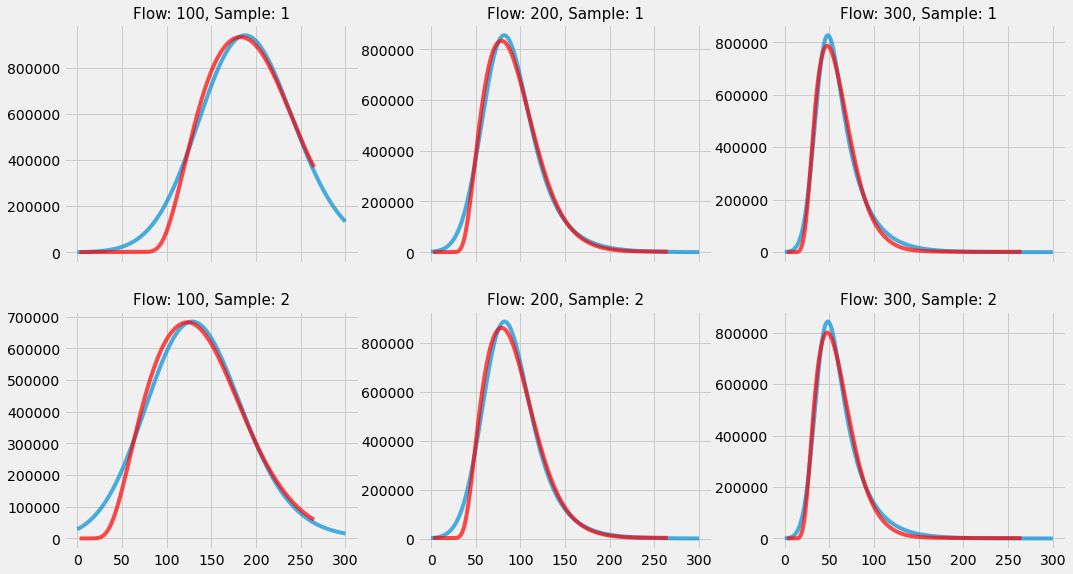

In [7]:
groups = sampled_df.groupby(["flow", "sample"]) # NON PARAMETRIC

plt.style.use("fivethirtyeight")

results_dict = {
    "flow": [],
    "sample": [],
    "mu": [],
    "mu_x": [],
    "lambda_": [],
    "sigma": [],
    "h": []
}

alkuarvaukset = [
        [2.4, 11, 0.041], # 300 alkuarvaus
        [4.6, 48, 0.022], # 100, 2
        [4.6, 48, 0.027], # 100, 1
        [3.6, 21, 0.041]
    ]

fig, axs = plt.subplots(2, 3, sharex=True, figsize=(16, 9))
for i, group in groups:
    if i[0] == 100:
        if i[1] == 1:
            alkuarvaus = alkuarvaukset[2]
        else:
            alkuarvaus = alkuarvaukset[1]
    elif i[0] == 300:
        alkuarvaus = alkuarvaukset[0]
    elif i[0] == 200:
        alkuarvaus = alkuarvaukset[3]
    mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus = alkuarvaus

    bounds = [(None, None), (1e-5, None), (1e-5, None), (None, None)]

    x_0 = [mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus, 1]
    res1 = scipy.optimize.minimize(EMG_loss, args=group, x0=x_0, bounds=bounds)
    x_range = np.linspace(0, 300, 900)
    mu = (group["input_x_max"] + res1["x"][0] * 1000 / group["flow"]).iloc[0]
    sigma = res1["x"][1]
    lambda_ = res1["x"][2]

    emg_params = {
        "mu_x": res1["x"][0],
        "sigma": sigma,
        "lambda_": lambda_
    }

    res2 = scipy.optimize.minimize(EMG_loss_h, args=(group, emg_params), x0=[80000])
    h = res2["x"][0]


    pred_y = EMG(x_range, mu, sigma, lambda_, h)

    # PLOTTING:
    row, column = i[1] - 1, int(i[0] / 100 - 1)

    axs[row, column].set_title(f"Flow: {i[0]}, Sample: {i[1]}", fontsize=15)
    axs[row, column].plot(x_range, pred_y, alpha=0.7)
    axs[row, column].plot(group["x"], group["s_tissue"], color="r", alpha=0.7)

    # Creating results dictionary
    results_dict["flow"].append(group["flow"].iloc[0])
    results_dict["sample"].append(group["sample"].iloc[0])
    results_dict["mu"].append(mu)
    results_dict["mu_x"].append(res1["x"][0])
    results_dict["sigma"].append(sigma)
    results_dict["lambda_"].append(lambda_)
    results_dict["h"].append(h)

fig.savefig("individual_optimizations")

results_df = pd.DataFrame(results_dict)
results_df = results_df.merge(feature_df, how="inner", on=["flow", "sample"])
results_df

In [8]:
param_dict = {
    "mu_x_count": 1,
    "sigma_count": 2,
    "lambda_count": 2,
    "h_count": 1
}

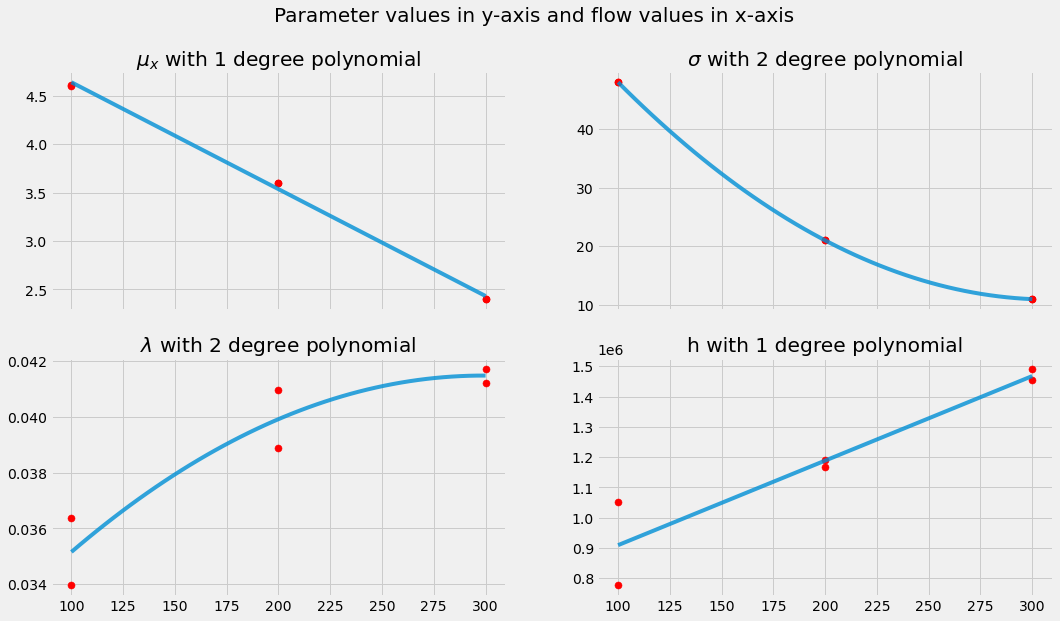

In [17]:
plot_all_params(results_df, param_dict, True)

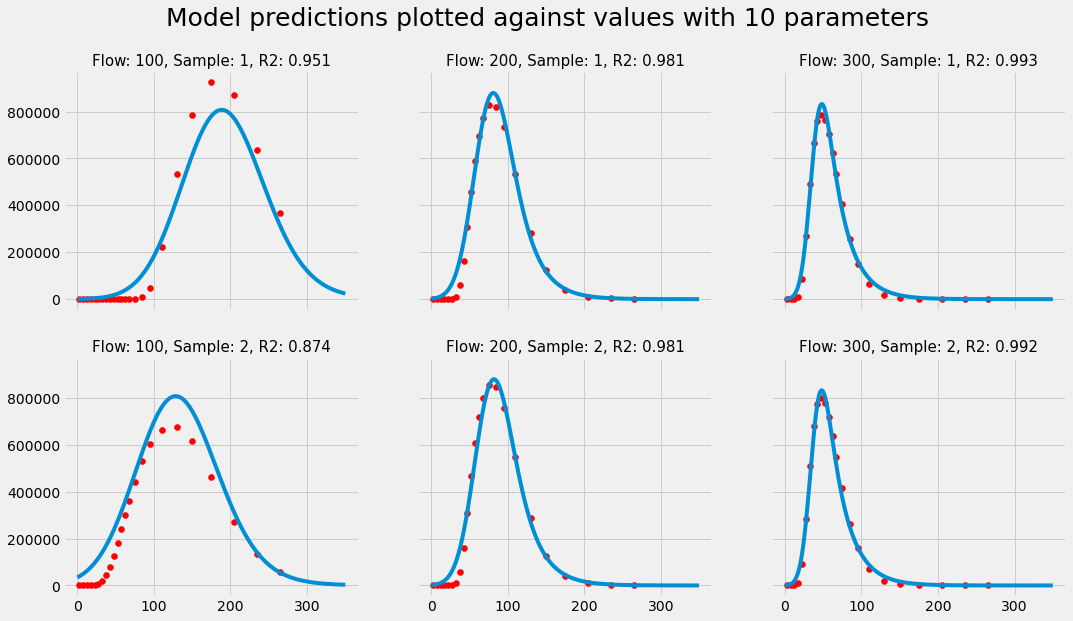

In [10]:
plot_against_predictions_all(results_df, df, param_dict, True)

R2 values are very biased downwards as we have the majority of the datapoints before t = 50 while we are actually more interested on the tail part of the curve.

y = exp(x * lambda_ + mu)

mu_x = 500 - 100 * flow

lambda = 0.038 + 0.02 * flow

mu = (input_x_max + mu_x * 100) / flow